In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/synthetic-airline-passenger-and-flight-data/synthetic_flight_passenger_data.csv


In [3]:
# Importing necessary libraries and suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Important if using full matplotlib.pyplot
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Needed if only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

%matplotlib inline

# Setting a style for seaborn plots
sns.set(style='whitegrid')

In [4]:
# Load the data from the CSV file
data_path = '/kaggle/input/synthetic-airline-passenger-and-flight-data/synthetic_flight_passenger_data.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

# Display the first few rows of the dataset
print('Shape of the data:', df.shape)
print('Data types:')
print(df.dtypes)

# Convert Departure_Time to datetime, infer format if possible
# Using 'coerce' will convert errors to NaT, a common practice for dealing with unexpected formats
df['Departure_Time'] = pd.to_datetime(df['Departure_Time'], errors='coerce', infer_datetime_format=True)

# Check for missing values in Departure_Time after conversion
missing_dates = df['Departure_Time'].isna().sum()
print(f"Number of missing or unparsable Departure_Time values: {missing_dates}")

# A quick look at the processed DataFrame
print(df.head())

Shape of the data: (10000, 25)
Data types:
Passenger_ID                  object
Flight_ID                     object
Airline                       object
Departure_Airport             object
Arrival_Airport               object
Departure_Time                object
Flight_Duration_Minutes        int64
Flight_Status                 object
Distance_Miles                 int64
Price_USD                    float64
Age                            int64
Gender                        object
Income_Level                  object
Travel_Purpose                object
Seat_Class                    object
Bags_Checked                   int64
Frequent_Flyer_Status         object
Check_in_Method               object
Flight_Satisfaction_Score    float64
Delay_Minutes                float64
Booking_Days_In_Advance        int64
No_Show                        int64
Weather_Impact                 int64
Seat_Selected                 object
Booking_Lead_Time              int64
dtype: object
Number of missing 

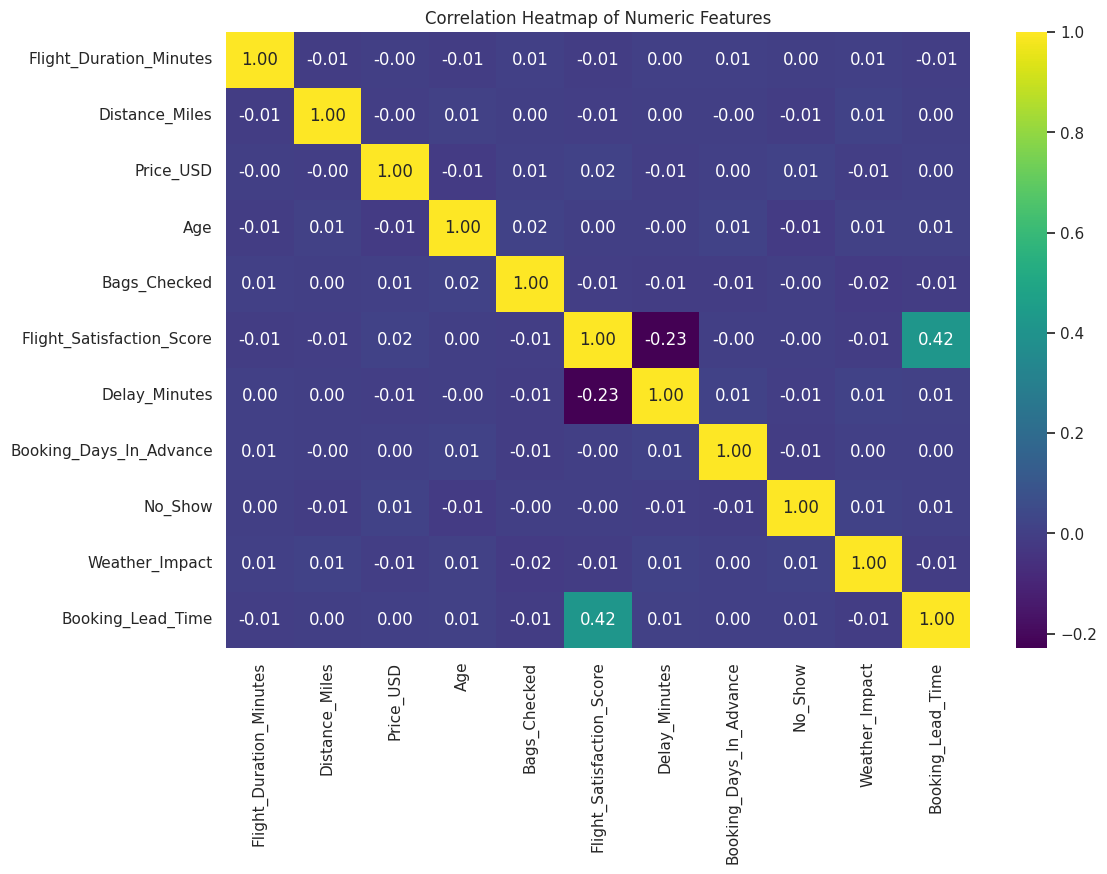

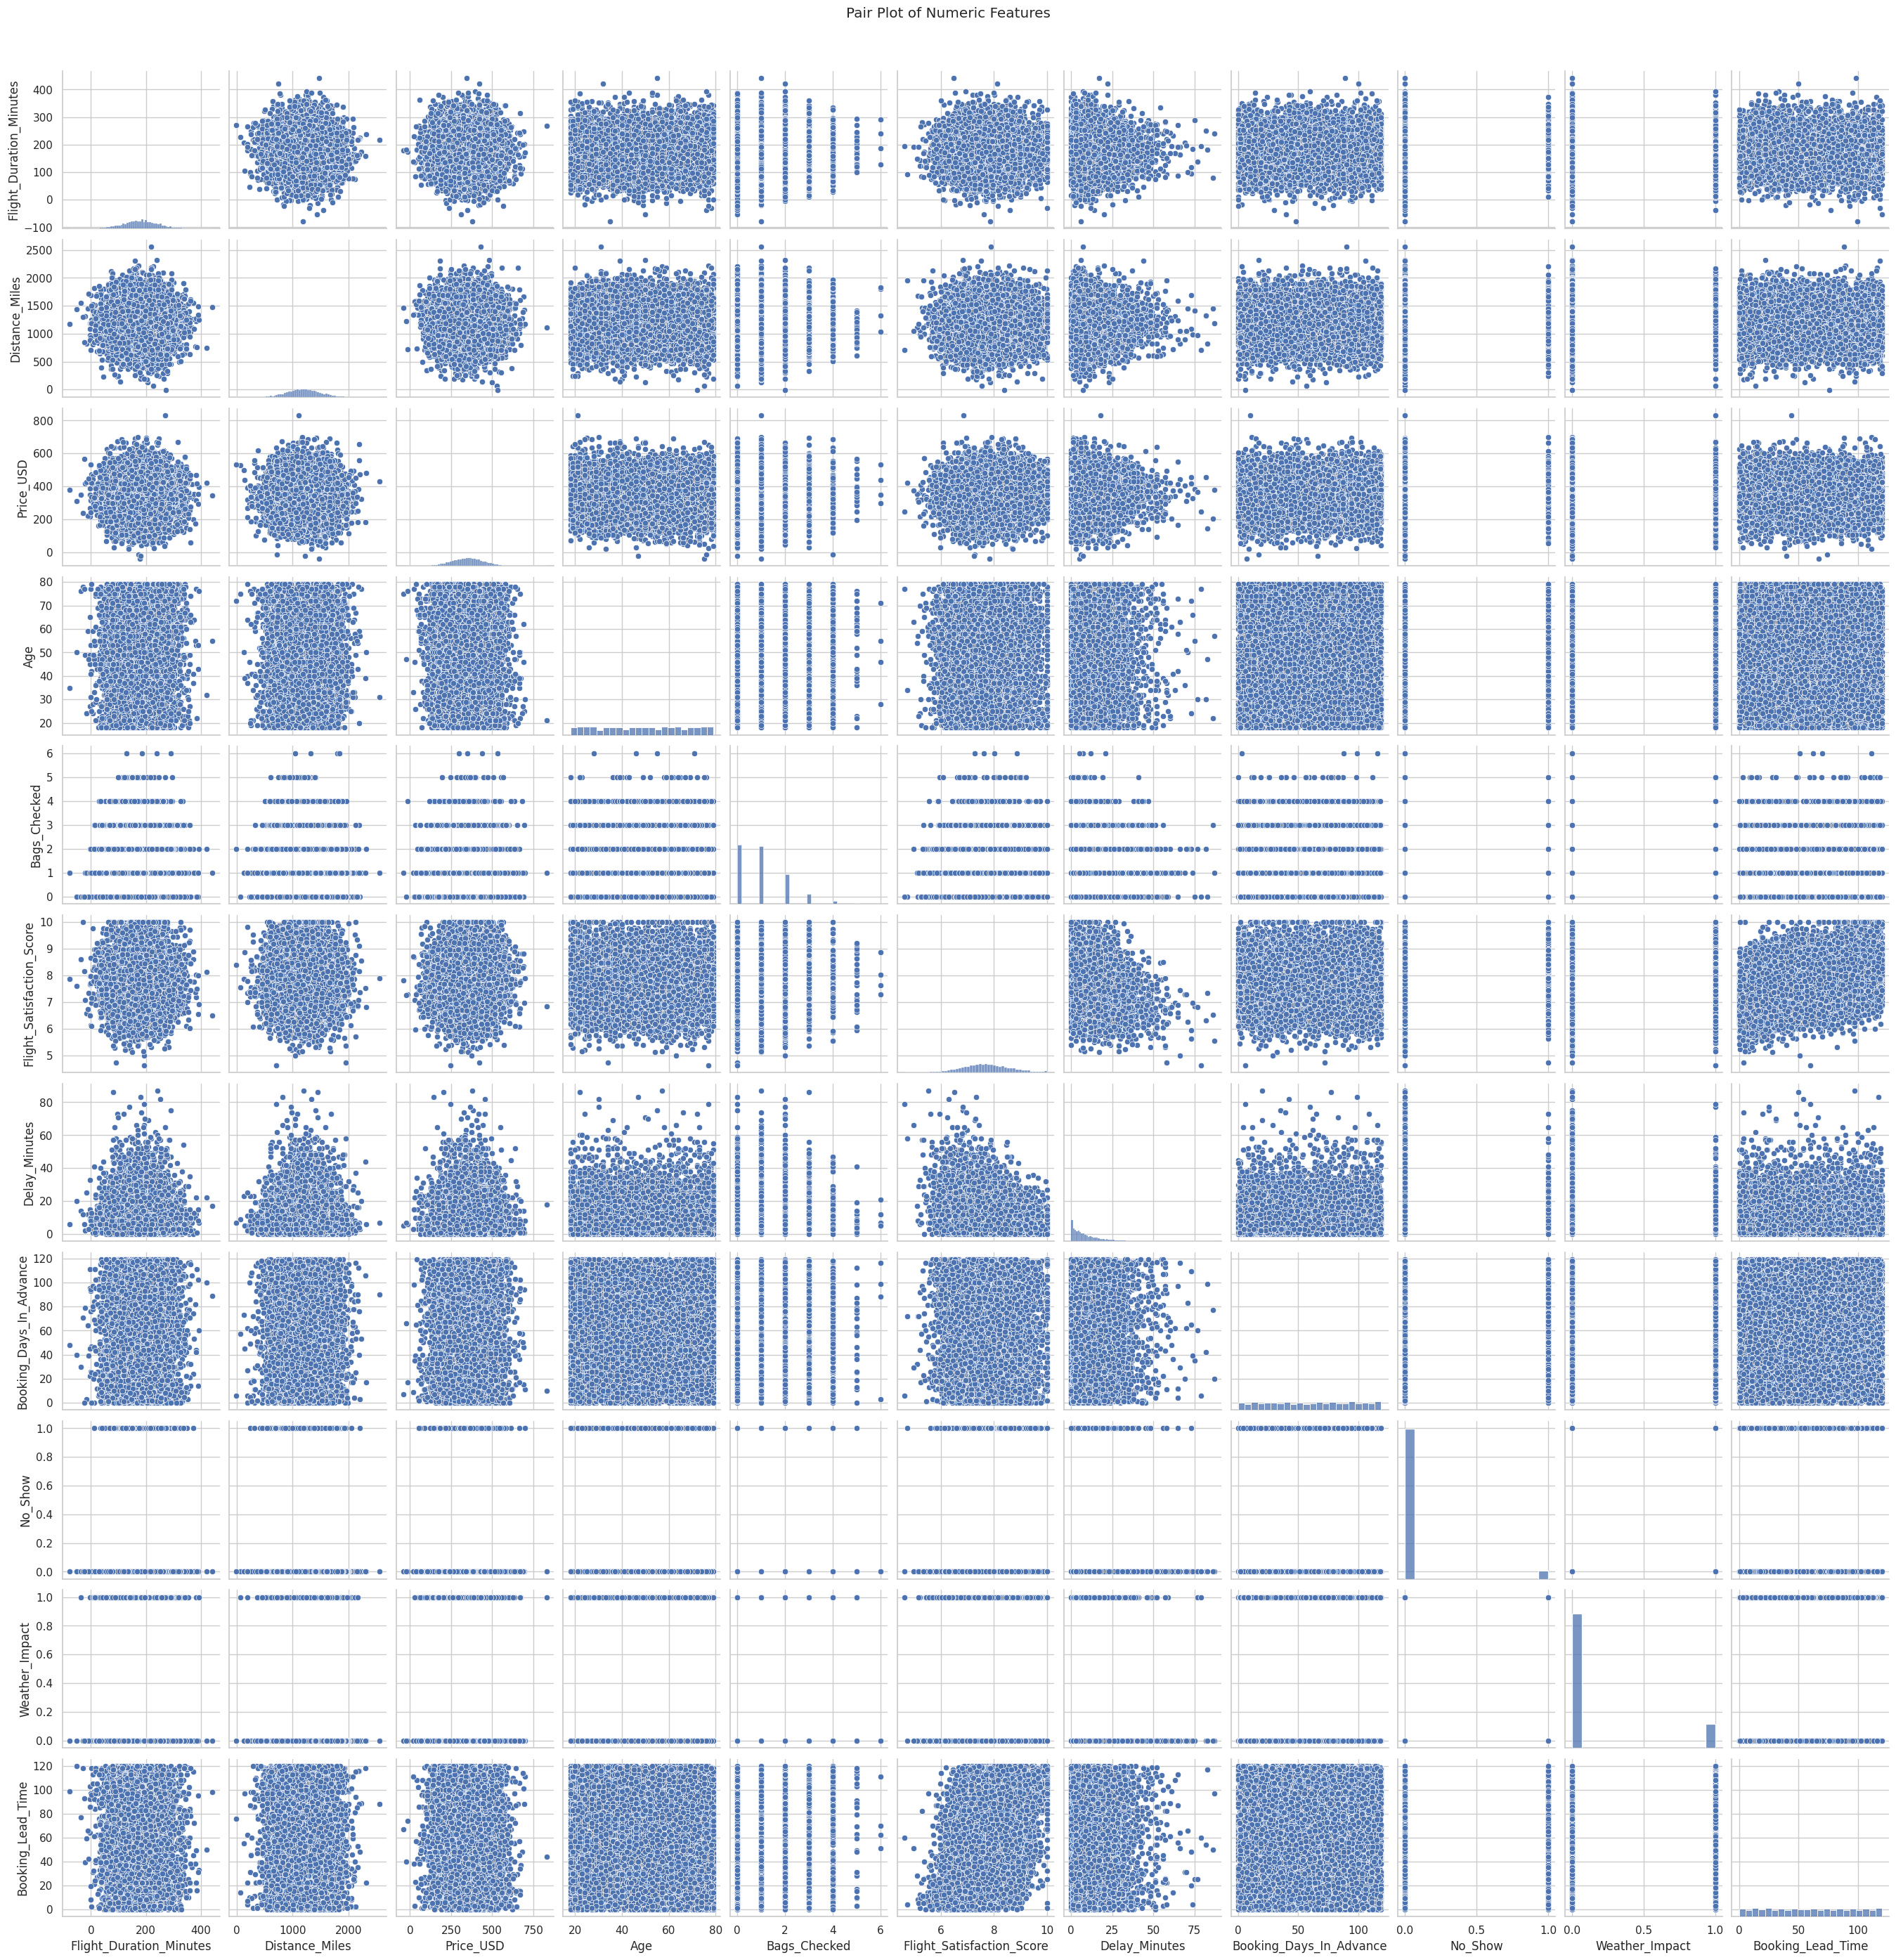

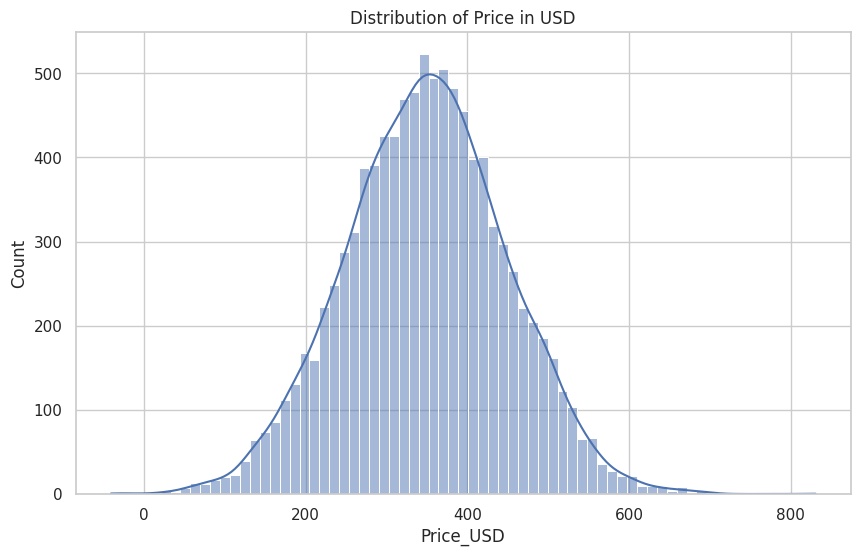

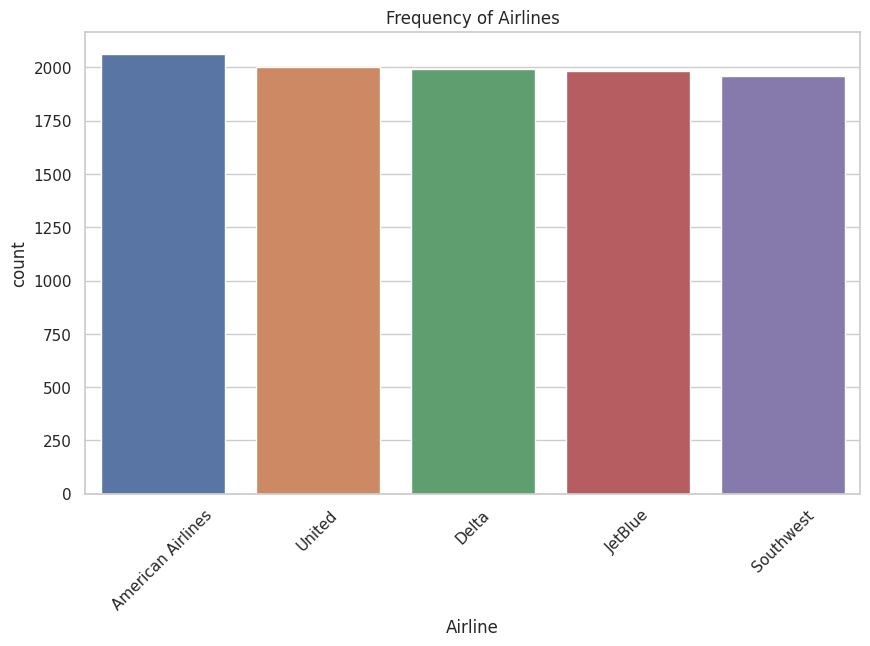

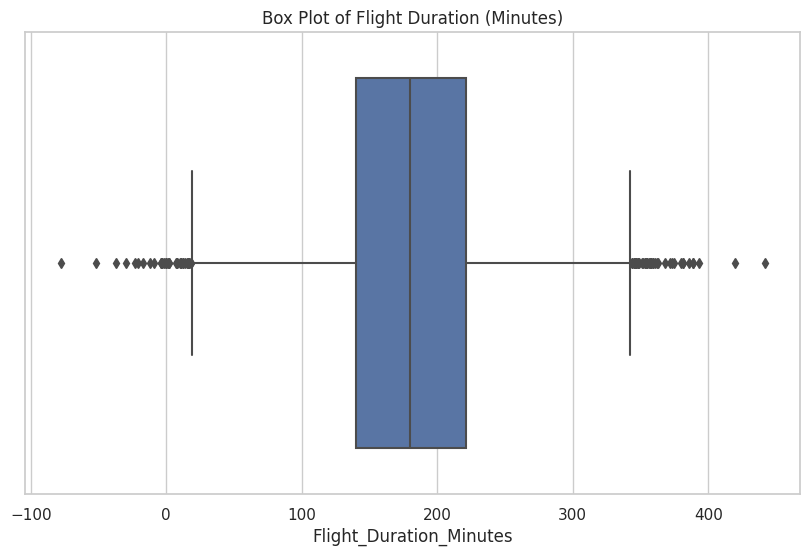

In [5]:
# Create a subset of only the numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12,8))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='viridis')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap.')

# Pair plot of numeric features (this can be heavy if too many columns; adjust as necessary)
sns.pairplot(numeric_df.dropna())
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

# Histogram for Price_USD distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Price_USD'].dropna(), kde=True)
plt.title('Distribution of Price in USD')
plt.show()

# Pie chart using countplot for Airline frequency
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Airline', order=df['Airline'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Frequency of Airlines')
plt.show()

# Box plot for Flight Duration Minutes
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Flight_Duration_Minutes')
plt.title('Box Plot of Flight Duration (Minutes)')
plt.show()

In [6]:

# Selecting predictor features
predictor_cols = ['Age', 'Flight_Duration_Minutes', 'Distance_Miles', 'Price_USD', 'Bags_Checked', 'Booking_Days_In_Advance', 'Delay_Minutes']

# Drop rows with missing data in these columns
df_predict = df[predictor_cols + ['No_Show']].dropna()

# Define X and y
X = df_predict[predictor_cols]
y = df_predict['No_Show']

print('Shape of predictor data:', X.shape)
print('Class distribution in target:')
print(y.value_counts())

Shape of predictor data: (10000, 7)
Class distribution in target:
No_Show
0    9489
1     511
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1894
           1       0.00      0.00      0.00       106

    accuracy                           0.95      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.90      0.95      0.92      2000



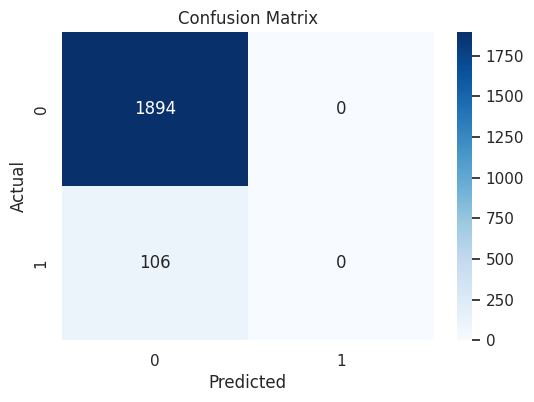

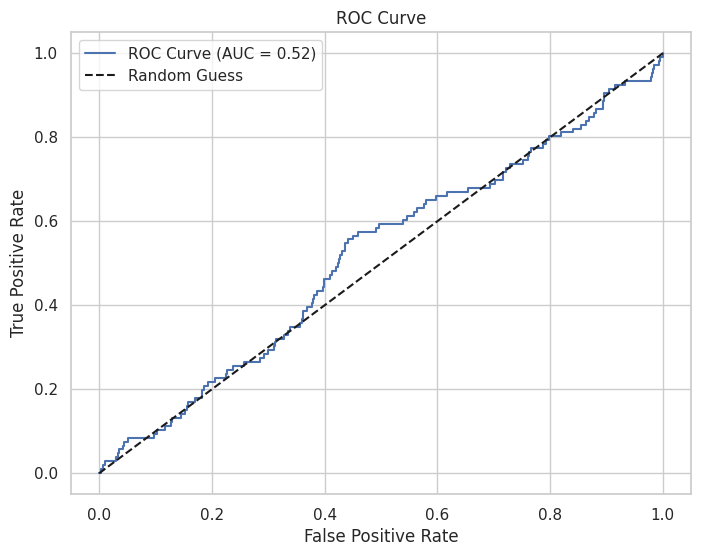

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve and AUC
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()